In [1]:
import sys
sys.path.append("../")
sys.path.append('C:\Users\James Pino\PycharmProjects\Magine')
from IPython.display import display
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import magine.ontology.enrichment_tools as et
from magine.plotting.heatmaps import  heatmap_from_array
from magine.plotting.wordcloud_tools import create_wordcloud
from magine.plotting.venn_diagram_maker import create_venn2
import seaborn as sns
from magine.data.tools import pivot_table
from magine.plotting.species_plotting import plot_list_of_genes
from magine.data.tools import log2_normalize_df

# load the experimental data
from exp_data import exp_data

# Visualize experimental data


In [7]:
display(exp_data.create_table_of_data())
display(exp_data.create_table_of_data(sig=True))
display(exp_data.create_table_of_data(sig=True, unique=True))

time,01hr,06hr,24hr,48hr,Total Unique Across
data_type,,,,,
C18,528.0,228.0,658.0,688,1411
HILIC,473.0,607.0,935.0,618,1512
label_free,3135.0,3091.0,2735.0,2504,4036
ph_silac,6903.0,10956.0,12176.0,11183,21924
rna_seq,18741.0,19104.0,19992.0,-,20642
silac,2923.0,3357.0,3072.0,3265,4086


time,01hr,06hr,24hr,48hr,Total Unique Across
data_type,,,,,
C18,528.0,228.0,658.0,688,1411
HILIC,473.0,607.0,935.0,618,1512
label_free,201.0,46.0,281.0,911,1149
ph_silac,594.0,1370.0,2414.0,1368,4757
rna_seq,73.0,1999.0,12215.0,-,12340
silac,38.0,52.0,228.0,266,485


time,01hr,06hr,24hr,48hr,Total Unique Across
data_type,,,,,
C18,527.0,227.0,657.0,687,1410
HILIC,472.0,606.0,934.0,617,1511
label_free,196.0,46.0,271.0,874,1085
ph_silac,514.0,888.0,1227.0,851,2278
rna_seq,73.0,1999.0,12215.0,-,12340
silac,38.0,52.0,228.0,266,485


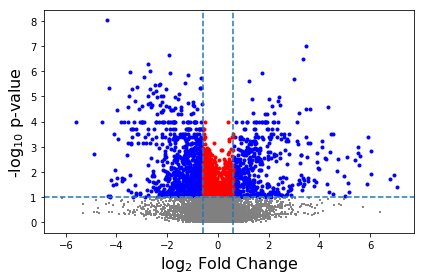

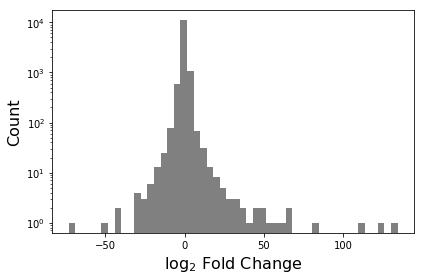

In [8]:
v_plot = exp_data.volcano_plot('label_free', 'lf_volcano')
hist_plot = exp_data.create_histogram_measurements('label_free', 'hist')

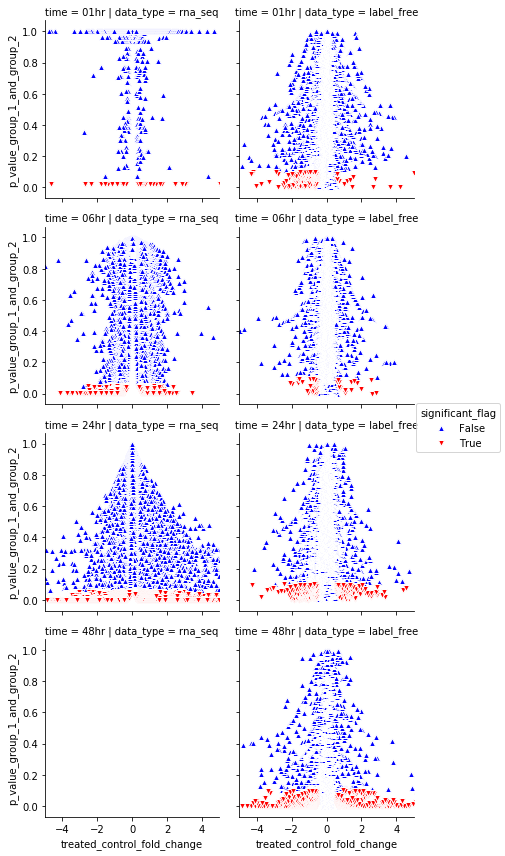

In [4]:
data = exp_data.data.copy()
data = data[data['data_type'].isin(['label_free', 'rna_seq'])]
data = log2_normalize_df(data, 'treated_control_fold_change')

grid = sns.FacetGrid(data, col="data_type", row='time', 
                     row_order=['01hr', '06hr', '24hr', '48hr' ],
                     hue='significant_flag',
                     hue_kws=dict(marker=["^", "v"], color=['blue', 'red']),
                    )

grid.map(plt.scatter, 
         "treated_control_fold_change", 
         "p_value_group_1_and_group_2", 
         marker="o",
         edgecolor="w",
        ).add_legend()

grid.set(xlim=(-5, 5))

plt.savefig('compare_fc_across_sample.png', dpi=300)

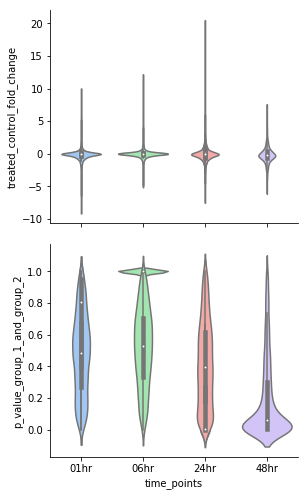

In [5]:
g = sns.PairGrid(data,
                 x_vars=['time_points'],
                 y_vars=[ "treated_control_fold_change", "p_value_group_1_and_group_2"],
                 hue="data_type",
                 aspect=1.25, size=3.5)
g.map(sns.violinplot, palette="pastel", 
                 split=True,);
g.fig.savefig('violin_plot-lf_rna_over_time.png', dpi=300)

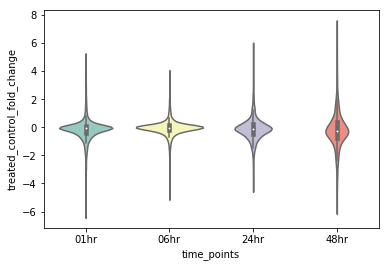

In [6]:

lf = data[data['data_type']=='label_free']
g = sns.violinplot(x="time_points", y="treated_control_fold_change", data=lf,
                   palette="Set3",order=sorted(data['time_points'].unique()) )

plt.savefig("violin_plot.png", dpi=300)

In [7]:
d = exp_data.data.copy()

In [8]:
met = d[d['data_type'].isin(['HILIC', 'C18'])].copy()
proteins = d[d['data_type'].isin(['label_free', 'silac', 'ph_silac'])].copy()
rna_seq = d[d['data_type'] == 'rna_seq'].copy()

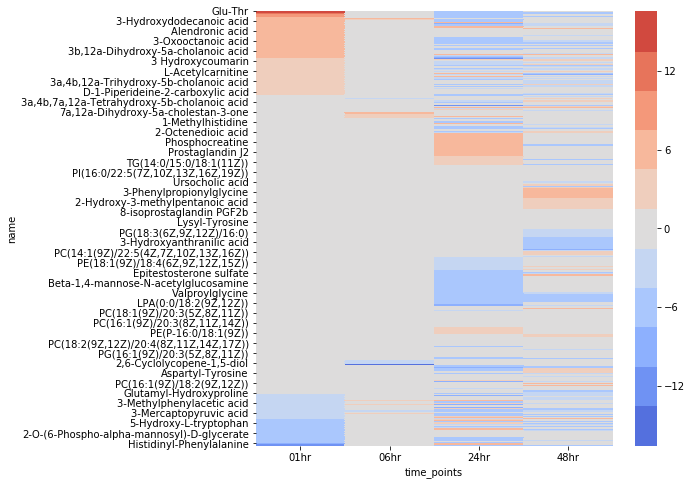

In [9]:
fig = heatmap_from_array(met, cluster_row=False, convert_to_log=True, 
                         index='name', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True, fig_size=(8, 8), num_colors=11)

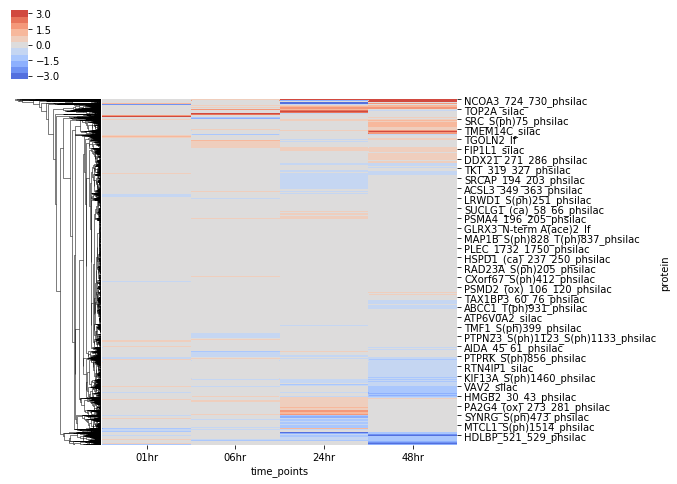

In [10]:
proteins.loc[proteins['treated_control_fold_change']>10, 'treated_control_fold_change']=10
proteins.loc[proteins['treated_control_fold_change']<-10, 'treated_control_fold_change']=-10

fig = heatmap_from_array(proteins, cluster_row=True, convert_to_log=True, 
                         index='protein', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True, fig_size=(8, 8),  num_colors=11)

fig.fig.savefig('proteins_clustered_time.png', dpi=250, bbox_inches='tight')

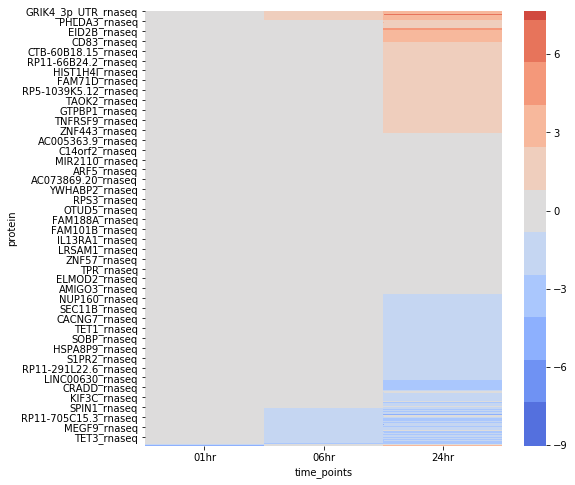

In [11]:
sig_rna = rna_seq[rna_seq['significant_flag']]
fig = heatmap_from_array(sig_rna, convert_to_log=True, cluster_row=False, 
                         index='protein', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True, fig_size=(8, 8), num_colors=11)

In [12]:
create_venn2(exp_data.list_rna, exp_data.list_proteins_non_rna, 'RNA', 'Protein', 'venn_rna_and_protein')

In [13]:
proteins = d[d['data_type'].isin(['label_free', 'silac', 'ph_silac'])].copy()
pivot = pivot_table(proteins, False, index='protein', values='treated_control_fold_change', 
                    columns='time_points' )
sig = pivot_table(proteins[proteins['significant_flag']], 
                  False, 
                  index='protein', 
                  values='treated_control_fold_change', 
                  columns='time_points' 
                 )
sig = (sig[['01hr','06hr', '24hr', '48hr' ]].T==0.).sum()
pivot = (pivot[['01hr','06hr', '24hr', '48hr' ]].T==0.).sum()


pivot = pivot[pivot<1]
sig = sig[sig<2]

criteria = set(pivot.index.values).intersection(sig.index.values)
tmp = proteins[proteins['protein'].isin(criteria)]
print(tmp.shape)



(840, 12)


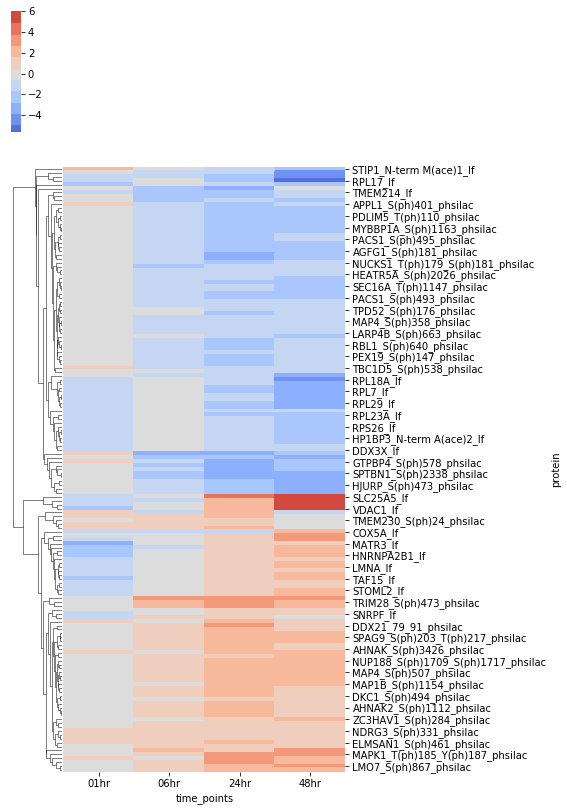

In [14]:
fig = heatmap_from_array(tmp, cluster_row=True, convert_to_log=True, 
                         index='protein', values='treated_control_fold_change', 
                         columns='time_points', div_colors=True, fig_size=(6,14),  num_colors=11)

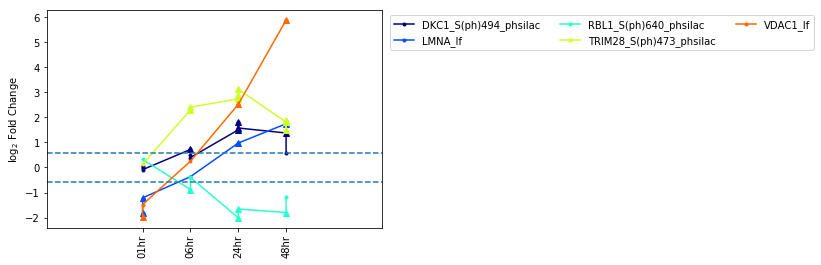

In [15]:
plot_list_of_genes(tmp, ['VDAC1', 'TRIM28', 'LMNA', 'RBL1','DKC1'], plot_type='matplotlib', 
                   save_name='proteins_timecour_example', 
                   image_format='png'
                  )

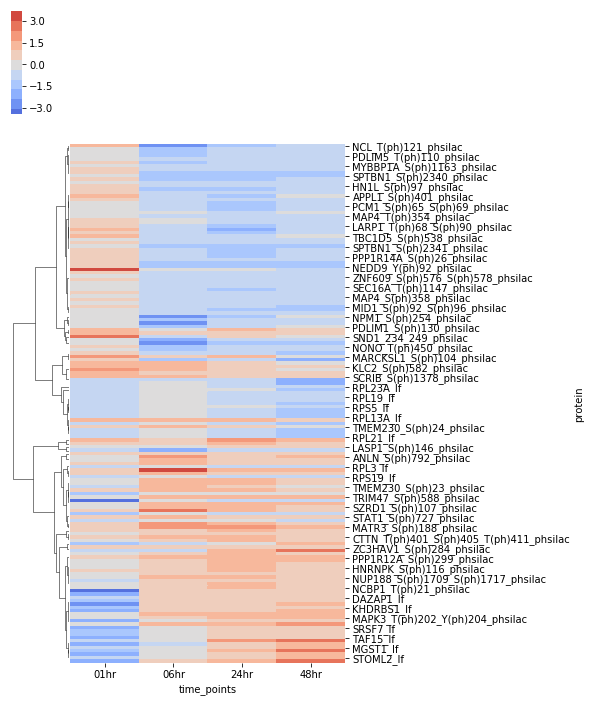

In [16]:
array = pivot_table(tmp, True, index='protein', values='treated_control_fold_change', 
                         columns='time_points', )

fig = sns.clustermap(array,
                     col_cluster=False, 
                     row_cluster=True, 
                     metric='correlation', 
                     figsize=(6,12),
#                      method='centroid',
                     z_score=1,
                     center=0, 
                     cmap=sns.color_palette("coolwarm", 11)
                    )

# Visualize enrichment output

In [17]:
process_dbs = [
        'GO_Biological_Process_2017',
        'Humancyc_2016',
        'Reactome_2016',
        'KEGG_2016',
        'NCI-Nature_2016',
        'Panther_2016',
        'WikiPathways_2016',
]
enrichment_array = pd.read_csv('Data/cisplatin_enrichment.csv.gz', index_col=0)

In [18]:

reactome_only = et.filter_dataframe(enrichment_array, p_value=0.05, combined_score=0.0,
                                     db='Reactome_2016',  category=['proteomics_up'])

drug_dbs = ['DrugMatrix', 'Drug_Perturbations_from_GEO_2014']

rna_drug_df = et.filter_dataframe(enrichment_array, p_value=0.05, combined_score=0.0, db=drug_dbs)

In [ ]:
sig_array = et.filter_dataframe(enrichment_array,
                                p_value=0.05, 
                                combined_score=5.0, 
                                rank=25
                               )
sig_array = et.remove_redundant(sig_array, threshold=0.7, verbose=False)

fig, _ = create_wordcloud(sig_array)
fig.plot(save_name='test_wc')

In [ ]:
fig, counts = create_wordcloud(rna_drug_df)
fig.plot(save_name='word_cloud_rna_drug_dbs')

In [ ]:
reactome_only = et.remove_redundant(reactome_only, threshold=0.7, verbose=False)

In [ ]:
fig = heatmap_from_array(reactome_only, convert_to_log=True, fig_size=(8, 8))
fig.savefig('enrichment.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = heatmap_from_array(reactome_only, convert_to_log=True, cluster_col=False, cluster_row=True, fig_size=(8, 8))
fig.savefig('cluster_enrichment.png', dpi=300, bbox_inches='tight')